# Model Gallary
This notebook demonstrates some of the ways that we experimented with different model archtiectures and datasets for settling on our choosen research problem. The findings shown here are not directly a part of our research and are not published in our results.

In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from datetime import date
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Flatten, Input, Activation, PReLU
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model
from IPython.display import display
from IPython.display import Image 
from statistics import mean 

In [2]:
# Set Styling
from simple_colors import *
sns.set_style('dark')
sns.set_palette('RdBu')

## Data Setup
Manipulate the song features data and Google trends data so that entries in each dataframe is indexed properly and such that only dates with entries in each dataframe are kept (i.e. if we have Google Trends data for October 11th, 2018, but we are lacking song features for that day, we should discard this data point for the purposes of modeling)

Test a variety of search term feature sets and song feature sets which have been manipulated in different ways

In [3]:
# Google Trends Data
individual_search_term_frequencies = pd.read_pickle('./pickles/individual_search_term_frequencies.pkl')
unscaled_relative_search_term_frequencies = pd.read_pickle('./pickles/unscaled_relative_search_term_frequencies.pkl')
scaled_relative_search_term_frequencies = pd.read_pickle('./pickles/scaled_relative_search_term_frequencies.pkl')

# Spotify data
top_200_weighted_avg = pd.read_pickle('./pickles/top_200_weighted_avg.pkl')
top_200_avg = pd.read_pickle('./pickles/top_200_avg.pkl')

# News vectors
news_vectors = pd.read_pickle('./pickles/news_vectors.pkl')

---
**Sort by date and reset indicies so that they match across dfs**

In [75]:
def sort_by_date(df):
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)

In [76]:
%%capture

sort_by_date(individual_search_term_frequencies)
sort_by_date(unscaled_relative_search_term_frequencies)
sort_by_date(scaled_relative_search_term_frequencies)
sort_by_date(top_200_weighted_avg)
sort_by_date(top_200_avg)
sort_by_date(news_vectors)

---
**Explore Data**

In [77]:
individual_search_term_frequencies.head() # scaled from 0 - 100

,date,anxiety,depression,OCD,hopeless,angry,afraid,apathy,worthless,worried,restless,irritable,tense,scattered,tired,avoiding,procrastinate,insomnia,suicidal,suicide
0,2017-01-01,73.0,65.0,73.0,58.0,99.0,58.0,52.0,52.0,57.0,59.0,71.0,46.0,40.0,68.0,50.0,64.0,71.0,84.0,100.0
1,2017-01-02,84.0,73.0,69.0,68.0,88.0,55.0,53.0,46.0,72.0,97.0,81.0,59.0,54.0,68.0,47.0,68.0,82.0,93.0,94.0
2,2017-01-03,90.0,75.0,71.0,63.0,79.0,54.0,72.0,76.0,80.0,96.0,80.0,69.0,44.0,71.0,63.0,65.0,89.0,85.0,78.0
3,2017-01-04,88.0,78.0,77.0,54.0,84.0,52.0,67.0,69.0,82.0,97.0,80.0,79.0,53.0,75.0,61.0,56.0,87.0,87.0,76.0
4,2017-01-05,91.0,78.0,72.0,66.0,84.0,54.0,65.0,51.0,64.0,81.0,81.0,81.0,71.0,70.0,60.0,57.0,85.0,86.0,78.0


In [78]:
unscaled_relative_search_term_frequencies.head() # scaled arbitrarily so that all term scores are comparable

,date,depression,anxiety,OCD,hopeless,angry,afraid,apathy,worthless,worried,...,irritable,tense,scattered,tired,avoiding,procrastinate,insomnia,suicidal,suicide,Term Scores Summed
0,2017-01-01,62.0,62.0,13.0,2.0,78.0,17.714286,1.968254,1.968254,3.936508,...,4.920635,21.650794,0.984127,26.303030,1.878788,0.939394,14.090909,6.526316,155.000000,491.611453
1,2017-01-02,69.0,70.0,13.0,3.0,69.0,17.742857,2.957143,0.985714,4.928571,...,5.914286,24.642857,1.971429,29.000000,3.000000,1.000000,18.000000,4.928571,144.571429,507.300000
2,2017-01-03,78.0,74.0,12.0,2.0,62.0,18.233766,3.038961,1.012987,5.064935,...,6.077922,29.376623,1.012987,29.376623,4.051948,1.012987,19.246753,5.086957,123.782609,499.700734
3,2017-01-04,78.0,76.0,14.0,2.0,67.0,18.233766,3.038961,2.025974,5.064935,...,7.090909,34.441558,2.025974,33.729730,3.162162,2.108108,20.027027,6.782609,125.478261,524.521663
4,2017-01-05,78.0,76.0,13.0,3.0,65.0,17.772152,2.962025,1.974684,3.949367,...,5.924051,34.556962,1.974684,32.582278,2.962025,1.974684,17.772152,6.638298,129.446809,514.249663


In [79]:
scaled_relative_search_term_frequencies.head() # scaled from 0-1000, where all term scores are comparable

,date,depression,anxiety,OCD,hopeless,angry,afraid,apathy,worthless,worried,...,irritable,tense,scattered,tired,avoiding,procrastinate,insomnia,suicidal,suicide,Term Scores Summed
0,2017-01-01,166.0,166.0,35.0,5.0,209.0,48.0,5.0,5.0,11.0,...,13.0,59.0,3.0,70.0,5.0,3.0,38.0,19.0,416.0,1322.0
1,2017-01-02,185.0,188.0,35.0,8.0,185.0,48.0,8.0,3.0,13.0,...,16.0,67.0,5.0,78.0,8.0,3.0,48.0,13.0,389.0,1364.0
2,2017-01-03,209.0,198.0,32.0,5.0,166.0,48.0,8.0,3.0,13.0,...,16.0,78.0,3.0,78.0,11.0,3.0,51.0,13.0,332.0,1334.0
3,2017-01-04,209.0,204.0,38.0,5.0,180.0,48.0,8.0,5.0,13.0,...,19.0,91.0,5.0,91.0,8.0,5.0,54.0,19.0,335.0,1401.0
4,2017-01-05,209.0,204.0,35.0,8.0,174.0,48.0,8.0,5.0,11.0,...,16.0,94.0,5.0,88.0,8.0,5.0,48.0,19.0,346.0,1382.0


In [80]:
top_200_avg.head() # all of top 200 songs are averaged, regardless of song popularity

,date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2017-01-01,0.681935,0.631440,5.345,-6.834550,0.595,0.133264,0.174817,0.010311,0.172115,0.507134,123.711640,219318.020,4.010
1,2017-01-02,0.676290,0.610385,5.215,-6.780710,0.560,0.141241,0.198055,0.007679,0.159602,0.442370,121.723755,223566.330,3.985
2,2017-01-03,0.674705,0.608545,5.235,-6.810915,0.555,0.140566,0.198139,0.007680,0.155095,0.439146,121.517035,222978.725,3.985
3,2017-01-04,0.675600,0.606130,5.215,-6.836510,0.555,0.142691,0.202651,0.007679,0.156017,0.437445,121.867565,222926.035,3.985
4,2017-01-05,0.678950,0.609420,5.240,-6.769335,0.560,0.146080,0.199928,0.007648,0.158186,0.442190,122.244085,223008.005,3.985


In [81]:
top_200_weighted_avg.head() # the weighted average of the songs in the top 200,
                            # where the weights are the number of streams per song

,date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,time_signature
0,2017-01-01,0.700672,0.620866,5.516916,-6.817967,0.618192,0.148352,0.175407,0.007983,0.166109,0.489005,124.906114,3.743462,4.010772
1,2017-01-02,0.694911,0.603411,5.401974,-6.817318,0.599963,0.154474,0.192934,0.006603,0.157463,0.440288,123.110631,3.780848,3.995896
2,2017-01-03,0.692630,0.602649,5.415236,-6.824104,0.596881,0.153246,0.194011,0.006792,0.154835,0.438192,122.733971,3.774221,3.995294
3,2017-01-04,0.692878,0.601787,5.338150,-6.832330,0.586901,0.154600,0.196601,0.006914,0.155729,0.437437,122.894072,3.772473,3.994701
4,2017-01-05,0.695205,0.602774,5.399846,-6.798211,0.598931,0.156652,0.196215,0.006865,0.155725,0.439196,123.133659,3.775106,3.994540


In [82]:
news_vectors.head() # 512 dimensional vectors representing the news on a given day

,date,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,2017-01-01,0.005954,-0.003841,-0.001854,-0.024854,-0.020176,0.011049,-0.004546,-0.001006,0.005869,...,0.003684,0.035374,0.016044,-0.000216,0.023061,-0.012140,-0.002986,-0.013999,-0.011632,0.008429
1,2017-01-02,0.000123,-0.025581,-0.003911,-0.019659,-0.016987,0.012803,0.007522,-0.009581,0.009210,...,-0.000628,0.020751,0.000568,0.004707,0.005168,-0.004014,-0.007200,0.003860,-0.017291,0.009441
2,2017-01-03,0.007024,-0.021057,0.000409,-0.025842,-0.016621,0.007097,0.000726,-0.007290,0.000116,...,-0.000661,0.030381,0.013288,0.005367,0.010509,-0.006045,-0.008171,0.003855,-0.007096,0.018201
3,2017-01-04,0.004653,-0.012411,-0.001151,-0.026045,-0.011844,0.010583,0.000069,-0.003124,0.006726,...,0.004361,0.025416,0.006094,0.008971,0.008110,0.000185,-0.012961,0.004362,-0.004057,0.010306
4,2017-01-05,0.003516,-0.004221,0.005870,-0.024142,-0.009221,0.011480,0.009126,-0.000250,0.004909,...,0.010125,0.020535,0.008477,0.003254,0.008739,-0.000438,-0.007905,0.002326,0.000348,0.014819


---
**Remove any entries which don't have a entries in all tables** (some dates are missing in both spotify data 
due to service outages and data collection problems experienced by Spotify or our data provider for Spotify,
Spotify Charts)

In [83]:
entries_in_all_dfs = pd.merge(left=scaled_relative_search_term_frequencies, 
                              right=unscaled_relative_search_term_frequencies, on='date')

entries_in_all_dfs = pd.merge(left=entries_in_all_dfs, 
                              right=individual_search_term_frequencies, on='date')

entries_in_all_dfs = pd.merge(left=entries_in_all_dfs, 
                              right=top_200_avg, on='date')

entries_in_all_dfs = pd.merge(left=entries_in_all_dfs, 
                              right=top_200_weighted_avg, on='date')

entries_in_all_dfs = pd.merge(left=entries_in_all_dfs, 
                              right=news_vectors, on='date')


shared_dates = entries_in_all_dfs['date']

In [84]:
# Keep only entries with dates that exist in all 3 dataframes
def keep_shared_dates(df, shared_dates):
    return df[df['date'].isin(shared_dates)]
    
individual_search_term_frequencies = keep_shared_dates(individual_search_term_frequencies, shared_dates)
unscaled_relative_search_term_frequencies = keep_shared_dates(unscaled_relative_search_term_frequencies, shared_dates)
scaled_relative_search_term_frequencies = keep_shared_dates(scaled_relative_search_term_frequencies, shared_dates)
top_200_weighted_avg = keep_shared_dates(top_200_weighted_avg, shared_dates)
top_200_avg = keep_shared_dates(top_200_avg, shared_dates)
news_vectors = keep_shared_dates(news_vectors, shared_dates)

In [85]:
individual_search_term_frequencies.reset_index(drop=True, inplace=True)
unscaled_relative_search_term_frequencies.reset_index(drop=True, inplace=True)
scaled_relative_search_term_frequencies.reset_index(drop=True, inplace=True)
top_200_weighted_avg.reset_index(drop=True, inplace=True)
top_200_avg.reset_index(drop=True, inplace=True)
news_vectors.reset_index(drop=True, inplace=True)

In [ ]:
# Save everything back to pickles
individual_search_term_frequencies.to_pickle('./pickles/individual_search_term_frequencies.pkl')
unscaled_relative_search_term_frequencies.to_pickle('./pickles/unscaled_relative_search_term_frequencies.pkl')
scaled_relative_search_term_frequencies.to_pickle('./pickles/scaled_relative_search_term_frequencies.pkl')
top_200_weighted_avg.to_pickle('./pickles/top_200_weighted_avg.pkl')
top_200_avg.to_pickle('./pickles/top_200_avg.pkl')
news_vectors.to_pickle('./pickles/news_vectors.pkl')

In [30]:
# Show number of missing dates
start = date(2017, 1, 1)
end = date(2020, 9, 29)
delta = end - start
print('Number of missing days:', delta.days - len(shared_dates))

Number of missing days: 3


## Define Training Process for LSTM Model

In [4]:
def plot_loss(history, title, label_name, save=False, fname=None):
    """
    Show the model's loss on training and validation data for each training epoch in the training trial
    """
    plt.title(title)
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylim([min(history.history['val_loss']), max(history.history['loss'])])
    plt.xlabel('Epoch')
    plt.ylabel('Error -' + label_name)
    plt.legend()
    plt.grid(True)
    
    # Display the figure
    figure = plt.gcf()
    display(figure)
    plt.close()

    
    if save:
        if fname is None:
            fname = './figures/history.png'
        
        plt.savefig(fname)

In [5]:
def plot_predictions(model, test_features, test_labels, model_name, label_name):
    
    test_predictions = model.predict(test_features).flatten()
    a = plt.axes(aspect='equal')
    
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [' + label_name + ']')
    plt.ylabel('Predictions [' + label_name + ']')
    lims = [min(test_predictions), max(test_predictions)]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

    # Display the figure
    figure = plt.gcf()
    display(figure)
    plt.close()
    
    # Output R^2 score for the predictions
    print(black('R-Squared Score of Predictions: ', ['bold']), end='')
    print(r2_score(y_true=test_labels, y_pred=test_predictions))

    plt.savefig('./figures/' + model_name + '_test_scatter_plot.png')

In [6]:
def get_rnn_data(data, labels, step):
    
    normalized_data = (data - data.mean()) / data.std()
    
    rnn_data = np.array([[[[]]]]) # 3D array
    samples = normalized_data.values.tolist()
    rnn_samples = []
    
    for i in range(step, len(samples) + 1): # Should be step x 13 sized arrays 
        sample_set = np.array(samples[i - step: i]) # previous 29 days, and the current day
        rnn_samples.append(sample_set)
        
        
    # Remove the first step - 1 days from the label set, since they're lacking enough data
    lstm_data = np.array(rnn_samples)
    labels = labels.iloc[step - 1:]
    
    return lstm_data, labels

In [7]:
def get_rnn_forecasting_data(data, labels, step):
    """
    To build the forecasting RNN, we simply add the trends scores from previous days in order to 
    predict the trend score for the current day.

    Input data:
    - Spotify data for day X + Google Trends search term scores data for day X
    - Spotify data for day (X + 1) + Google Trends search term scores data for day (X + 1)
    - ... (all data for days X + 2 through day Y)
    - Spotify data for day Y + Google Trends search term scores for day Y

    Label (Item to predict):
    - Google Trends search term scores for day Y + 1 (the next day)
    
    """
    normalized_spotify_data = (data - data.mean()) / data.std()
    normalized_trends = (labels - labels.mean()) / labels.std()
    spotify_list = normalized_spotify_data.values.tolist()
    trends_list = normalized_trends.tolist()
    rnn_samples = []
    
    for i in range(step, len(spotify_list) - 1): # Should be step x 13 sized arrays 

        spotify_features = np.array(spotify_list[i - step: i])
        trends_data = np.array(trends_list[i - step: i])
        trends_data = np.expand_dims(trends_data, axis=1)

        sample_set = np.concatenate((spotify_features, trends_data), axis=1) # previous 30 days
        rnn_samples.append(sample_set)

        
    # start at step + 1, so that we are forecasting the next day
    lstm_data = np.array(rnn_samples)
    labels = labels.iloc[step + 1:]
    
    return lstm_data, labels

In [8]:
def get_trends_only_rnn_forecasting_data(labels, step):
    """
    Output:
    ------
    Data: 30 days of Google Trends scores from day (X) to day (X + n)
    Labels: 1 Goolgle Trend score on day (X + n + 1)
    """
    normalized_trends = (labels - labels.mean()) / labels.std()
    trends_list = normalized_trends.tolist()
    rnn_samples = []
    
    for i in range(step, len(trends_list) - 1): # Should be step x 13 sized arrays 
        
        trends_data = np.array(trends_list[i - step: i])
        trends_data = np.expand_dims(trends_data, axis=1)

        sample_set = trends_data
        rnn_samples.append(sample_set)

        
    # start at step + 1, so that we are forecasting the next day
    lstm_data = np.array(rnn_samples)
    labels = labels.iloc[step + 1:]
    
    return lstm_data, labels

In [9]:
def get_rnn_forecasting_data_monthly_predictions(data, labels, step):
    normalized_spotify_data = (data - data.mean()) / data.std()
    normalized_trends = (labels - labels.mean()) / labels.std()
    spotify_list = normalized_spotify_data.values.tolist()
    trends_list = normalized_trends.tolist()
    rnn_samples = []
    
    for i in range(step, len(spotify_list) - 30):

        spotify_features = np.array(spotify_list[i - step: i])
        trends_data = np.array(trends_list[i - step: i])
        trends_data = np.expand_dims(trends_data, axis=1)

        sample_set = np.concatenate((spotify_features, trends_data), axis=1) # previous 30 days
        rnn_samples.append(sample_set)

    lstm_data = np.array(rnn_samples)
    labels = labels.iloc[step:]
    
    month_scores = []
    label_list = labels.to_list()
    for i in range(30, len(label_list)):
        month_score = mean(label_list[i-30: i]) # get the mean score for the previous 30 days
        month_scores.append(month_score)
        
    labels = pd.Series(np.array(month_scores))
    
    return lstm_data, labels

In [10]:
def get_rnn_forecasting_data_monthly_predictions_spotify_only(data, labels, step):
    
    normalized_spotify_data = (data - data.mean()) / data.std()
    spotify_list = normalized_spotify_data.values.tolist()
    rnn_samples = []
    
    for i in range(step, len(spotify_list) - 30):

        spotify_features = np.array(spotify_list[i - step: i])
        sample_set = spotify_features # previous 30 days
        rnn_samples.append(sample_set)

    lstm_data = np.array(rnn_samples)
    labels = labels.iloc[step:]
    
    month_scores = []
    label_list = labels.to_list()
    for i in range(30, len(label_list)):
        month_score = mean(label_list[i-30: i]) # get the mean score for the previous 30 days
        month_scores.append(month_score)
        
    labels = pd.Series(np.array(month_scores))
    
    return lstm_data, labels

In [11]:
def get_rnn_forecasting_data_monthly_predictions_baseline(labels, step):
    
    normalized_trends = (labels - labels.mean()) / labels.std()
    trends_list = normalized_trends.tolist()
    rnn_samples = []
    
    for i in range(step, len(trends_list) - 30):
        
        trends_data = np.array(trends_list[i - step: i])
        trends_data = np.expand_dims(trends_data, axis=1)

        sample_set = trends_data
        rnn_samples.append(sample_set)

    lstm_data = np.array(rnn_samples)
    labels = labels.iloc[step:]
    
    month_scores = []
    label_list = labels.to_list()
    for i in range(30, len(label_list)):
        month_score = mean(label_list[i-30: i]) # get the mean score for the previous 30 days
        month_scores.append(month_score)
        
    labels = pd.Series(np.array(month_scores))
    
    return lstm_data, labels

In [12]:
def train_lstm_model(data, labels, step, model_name, label_name, model_type, epochs=1000):
    
    # Transform data to RNN format (each sample is a 2D input of size num_days * num_features)
    if model_type == 'one_day_forecasting':
        lstm_data, labels = get_rnn_forecasting_data(data, labels, step)
        input_layer_name = 'Spotify_Features_And_Trends_Scores_' + str(step) + '_Days'
    
    # Trends data only
    elif model_type == 'one_day_forecasting_baseline':
        lstm_data, labels = get_trends_only_rnn_forecasting_data(labels, step)
        input_layer_name = 'Trends_Scores_Only_' + str(step) + '_Days'
    
    # Monthly Forecasting with Spotify + Trends
    elif model_type == 'monthly_forecasting':
        lstm_data, labels = get_rnn_forecasting_data_monthly_predictions(data, labels, step)
        input_layer_name = 'Spotify_Features_And_Trends_Scores_' + str(step) + '_Days'
    
    # Monthly Forecasting with Trends only
    elif model_type == 'monthly_forecasting_baseline':
        lstm_data, labels = get_rnn_forecasting_data_monthly_predictions_baseline(labels, step)
        input_layer_name = 'Trends_Scores_Only_' + str(step) + '_Days'
    
    # Monthly Forecasting with Spotify only
    elif model_type == 'monthly_forecasting_spotify_only':
        lstm_data, labels = get_rnn_forecasting_data_monthly_predictions_spotify_only(data, labels, step)
        input_layer_name = 'Spotify_Data_Only_' + str(step) + '_Days'
        
    # Montly Forecasting with NYT Only
    elif model_type == 'monthly_forecasting_nyt_only':
        lstm_data, labels = get_rnn_forecasting_data_monthly_predictions_spotify_only(data, labels, step)
        input_layer_name = 'NYT_Data_Only_' + str(step) + '_Days'
        
    # Monthly Forecasting with Spotify + New York Times Data
    elif model_type == 'monthly_forecasting_spotify_and_nyt':
        lstm_data, labels = get_rnn_forecasting_data_monthly_predictions_spotify_only(data, labels, step)
        input_layer_name = 'Spotify_And_NYT_' + str(step) + '_Days'
        
    # Monthly Forecasting with Spotify + NYT Data + Trends 
    elif model_type == 'monthly_forecasting_spotify_nyt_and_trends':
        lstm_data, labels = get_rnn_forecasting_data_monthly_predictions(data, labels, step)
        input_layer_name = 'Spotify_NYT_And_Trends_' + str(step) + '_Days'
        
    elif model_type == 'standard':
        lstm_data, labels = get_rnn_data(data, labels, step)
        input_layer_name = 'Spotify_Features_' + str(step) + '_Days'

    # Train test split
    random_state = 101
    train_features, test_features, train_labels, test_labels = train_test_split(lstm_data, labels, test_size=0.2, random_state=random_state)
    
    # Build and compile the model
    rnn_model = tf.keras.Sequential([
        layers.Input(shape=lstm_data[0].shape, name=input_layer_name),
        layers.LSTM(256, return_sequences=True),
        layers.LSTM(128),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1) # regression output
    ])
    rnn_model.compile(loss="mean_absolute_error",
        optimizer=tf.keras.optimizers.Nadam(0.001))
    
    # Plot the model
    model_image_filename = 'figures/' + model_name + '.png'
    plot_model(
        rnn_model, to_file=model_image_filename, show_shapes=True, show_layer_names=True, 
        rankdir='LR', expand_nested=False, dpi=96
    )
    print(black('Model Architecture', ['bold']))
    print(black('------------------', ['bold']))
    display(Image(model_image_filename))

    # Use multiple CPU cores if available
    workers = multiprocessing.cpu_count()
    use_multiprocessing = workers > 1

    # LSTMs tend to be more sporadic in terms of validation accuracy, so we will increase the patience to 100 for this model
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=100)
    
    # Train the model
    history = rnn_model.fit(
        train_features, train_labels,
        batch_size=128, # batch size shoud be a power of 2
        validation_split=0.2, # 20% of data saved for validation
        callbacks=[early_stop], # stop when model begins overfitting
        verbose=0, # set to 1 to see validation accuracy at end of each training step
        epochs=epochs, # maximum training epochs (if model does not stop early)
        workers=workers, 
        use_multiprocessing=use_multiprocessing)
    
    # Evaluate the Model
    print(black('\nTraining History', ['bold']))
    print(black('----------------', ['bold']))

    # Check Training History
    plot_loss(history=history,
          title= model_name + ': Training and Validation Loss',
          label_name=label_name,
          save=True,
          fname='figures/' + model_name + '_training.png')
    
    
    # Evaluate the Model
    print(black('\nModel Evaluation', ['bold']))
    print(black('----------------', ['bold']))
    
    # Get baselines
    print('  * Mean Absolute Deviation of train response values:', train_labels.mad())
    print('  * Mean Absolute Deviation of test response values:', test_labels.mad())
    
    # Get validation set performance
    print('  * Mean Absolute Error on Validation Set:', min(history.history['val_loss']))
    
    # Get model performance on test set
    mae = rnn_model.evaluate(test_features, test_labels, verbose=0)
    print('  * Mean Absolute Error on Test Set:', mae)
    
    # Plot True Value vs Predicted Value plot
    plot_predictions(rnn_model, test_features, test_labels, model_name, label_name)
    
    # Return the model
    return rnn_model

### Test how the same model architecture performs with different datasets and labelsets

**Two Feature Sets**:
- Unweighted average spotify top 200 data found in the top_200_weighted_avg
- Weighted average spotify top 200 data found in top_200_avg

**Three labelsets**:
- Anxiety term score, found in individual_search_term_frequencies dataset
- Search Terms Summed score, found in unscaled_relative_search_term_frequencies
- Search Terms Summed score, found in scaled_relative_search_term_frequencies

**Thus**:

2 * 3 = 6 models to test

Model Architecture
------------------


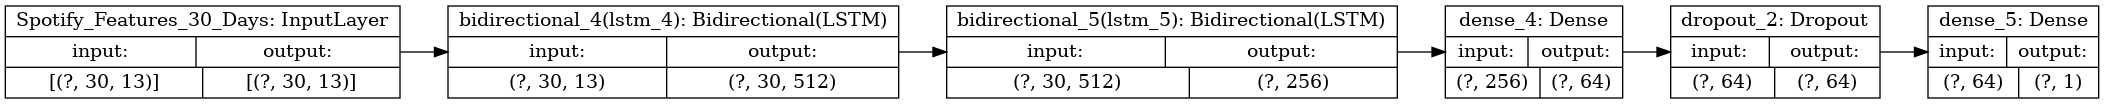


Training History
----------------


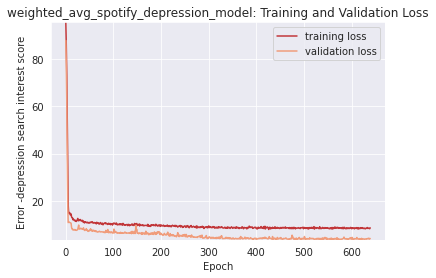


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 10.996523306475261
  * Mean Absolute Deviation of test response values: 11.485107751471427
  * Mean Absolute Error on Validation Set: 3.50787091255188
  * Mean Absolute Error on Test Set: 3.881124973297119


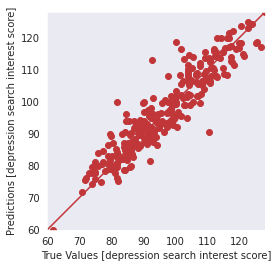

<Figure size 432x288 with 0 Axes>

In [22]:
# Weighted top 200 with depression labels
train_lstm_model(data=top_200_weighted_avg.drop(columns=['date']),
                 labels=individual_search_term_frequencies['anxiety'],
                 step=30,
                 model_name='weighted_avg_spotify_anxiety_model',
                 label_name='anxiety search interest score'
                 model_type='standard')

Model Architecture
------------------


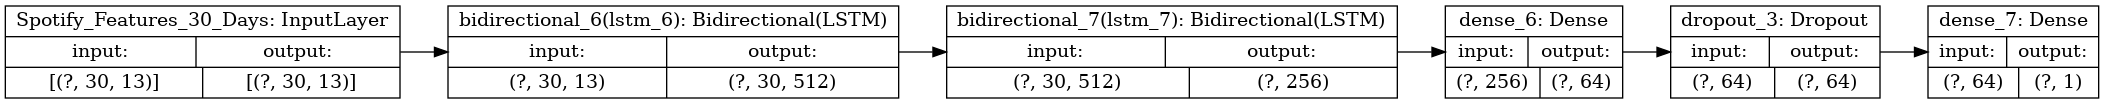


Training History
----------------


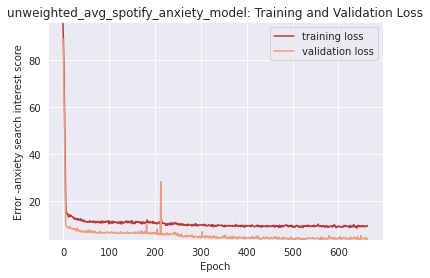


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 10.996523306475261
  * Mean Absolute Deviation of test response values: 11.485107751471427
  * Mean Absolute Error on Validation Set: 3.5746665000915527
  * Mean Absolute Error on Test Set: 4.248610019683838


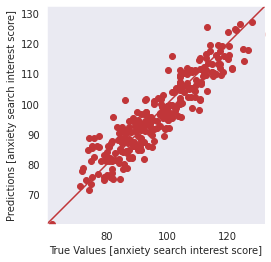

<Figure size 432x288 with 0 Axes>

In [28]:
# Unweighted top 200 with depression labels
train_lstm_model(data=top_200_avg.drop(columns=['date']),
                 labels=individual_search_term_frequencies['anxiety'],
                 step=30,
                 model_name='unweighted_avg_spotify_anxiety_model',
                 label_name='anxiety search interest score',
                 model_type='standard')

Model Architecture
------------------


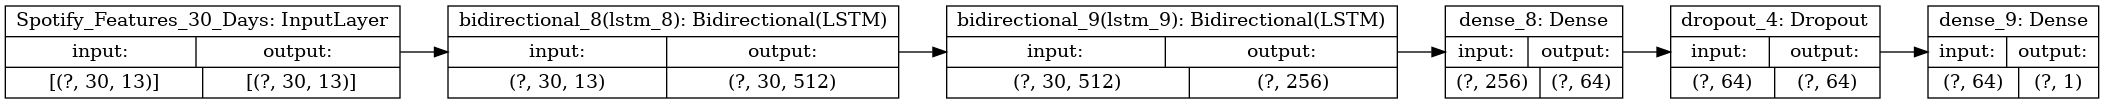


Training History
----------------


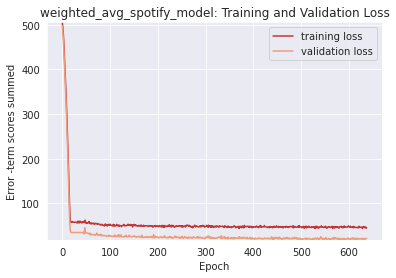


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 35.50495279775713
  * Mean Absolute Deviation of test response values: 37.72706439199718
  * Mean Absolute Error on Validation Set: 18.680871963500977
  * Mean Absolute Error on Test Set: 19.79180335998535


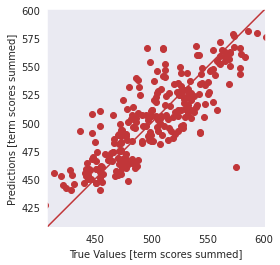

<Figure size 432x288 with 0 Axes>

In [29]:
# Weighted top 200 with term scores summed labels (unscaled)
train_lstm_model(data=top_200_weighted_avg.drop(columns=['date']),
                 labels=unscaled_relative_search_term_frequencies['Term Scores Summed'],
                 step=30,
                 model_name='weighted_avg_spotify_model',
                 label_name='term scores summed',
                 model_type='standard')

Model Architecture
------------------


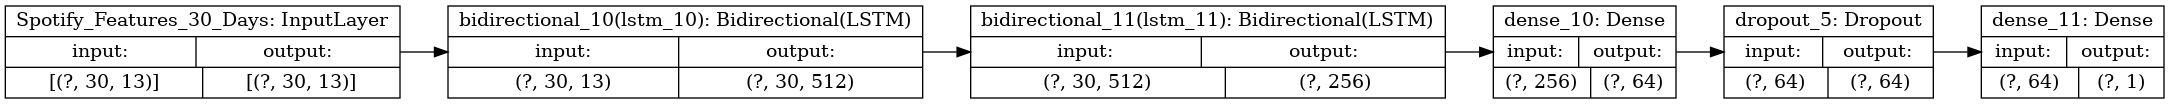


Training History
----------------


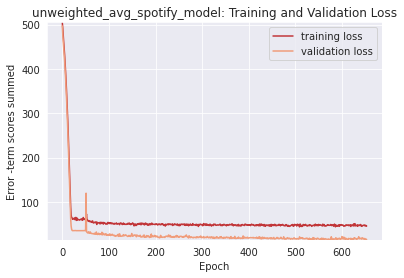


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 35.50495279775713
  * Mean Absolute Deviation of test response values: 37.72706439199718
  * Mean Absolute Error on Validation Set: 14.47285270690918
  * Mean Absolute Error on Test Set: 17.557273864746094


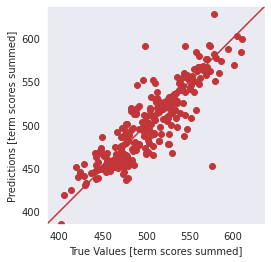

<Figure size 432x288 with 0 Axes>

In [30]:
# Unweighted top 200 with term scores summed labels (unscaled)
train_lstm_model(data=top_200_avg.drop(columns=['date']),
                 labels=unscaled_relative_search_term_frequencies['Term Scores Summed'],
                 step=30,
                 model_name='unweighted_avg_spotify_model',
                 label_name='term scores summed',
                 model_type='standard')

Model Architecture
------------------


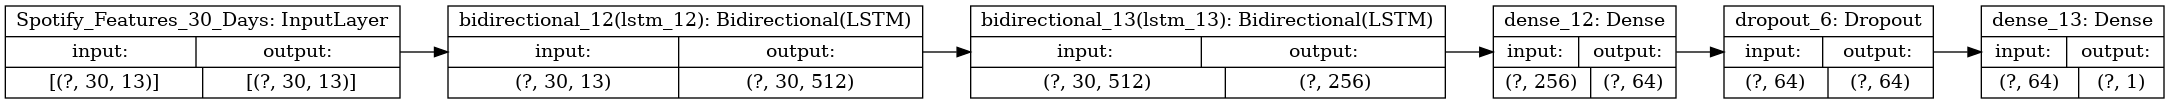


Training History
----------------


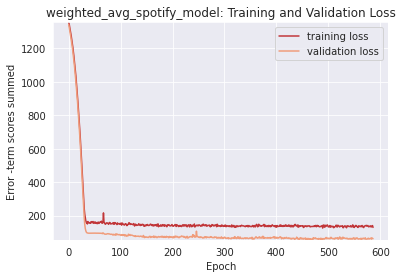


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 95.72726156910603
  * Mean Absolute Deviation of test response values: 101.77520049008687
  * Mean Absolute Error on Validation Set: 55.3421516418457
  * Mean Absolute Error on Test Set: 60.267860412597656


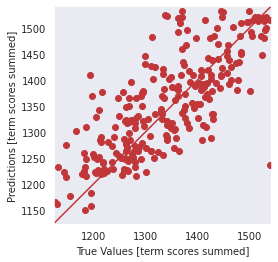

<Figure size 432x288 with 0 Axes>

In [31]:
# Weighted top 200 with term scores summed labels (scaled)
train_lstm_model(data=top_200_weighted_avg.drop(columns=['date']),
                 labels=scaled_relative_search_term_frequencies['Term Scores Summed'],
                 step=30,
                 model_name='weighted_avg_spotify_model',
                 label_name='term scores summed',
                 model_type='standard')

Model Architecture
------------------


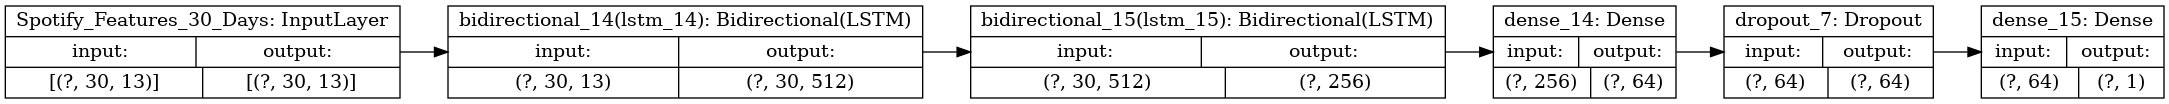


Training History
----------------


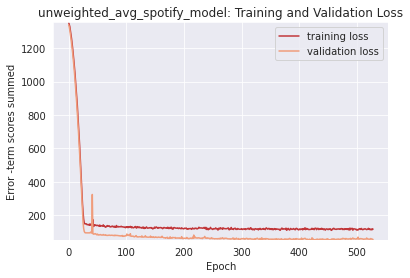


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 95.72726156910603
  * Mean Absolute Deviation of test response values: 101.77520049008687
  * Mean Absolute Error on Validation Set: 53.028018951416016
  * Mean Absolute Error on Test Set: 62.08818054199219


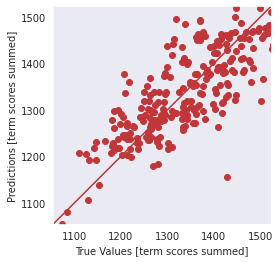

<Figure size 432x288 with 0 Axes>

In [32]:
# Unweighted top 200 with term scores summed labels (unscaled)
train_lstm_model(data=top_200_avg.drop(columns=['date']),
                 labels=scaled_relative_search_term_frequencies['Term Scores Summed'],
                 step=30,
                 model_name='unweighted_avg_spotify_model',
                 label_name='term scores summed',
                 model_type='standard')

## The results above show that 
the LSTM trained with weighted spotify data to predict the term scores for anxiety was the highest performing model. We will now use this featureset/ labelset combo to build all future models.


### Build One-Day Forecasting Model

Model Architecture
------------------


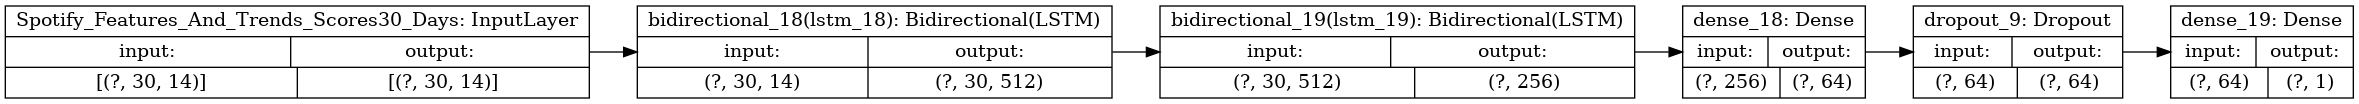


Training History
----------------


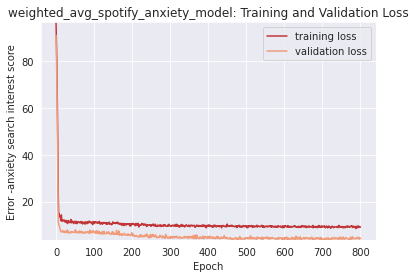


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 10.961180821561653
  * Mean Absolute Deviation of test response values: 11.608314071517949
  * Mean Absolute Error on Validation Set: 3.7377207279205322
  * Mean Absolute Error on Test Set: 4.232853889465332


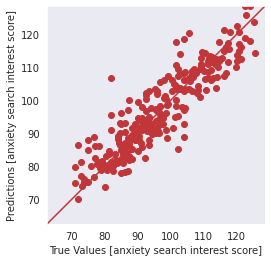

<Figure size 432x288 with 0 Axes>

In [43]:
# Weighted top 200 with depression labels
train_lstm_model(data=top_200_weighted_avg.drop(columns=['date']),
                 labels=individual_search_term_frequencies['anxiety'],
                 step=30,
                 model_name='weighted_avg_spotify_anxiety_model_one_day_forecasting',
                 label_name='anxiety search interest score',
                 model_type='one_day_forecasting')

Model Architecture
------------------


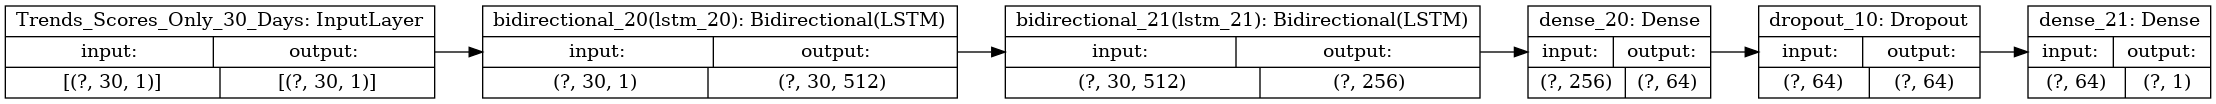


Training History
----------------


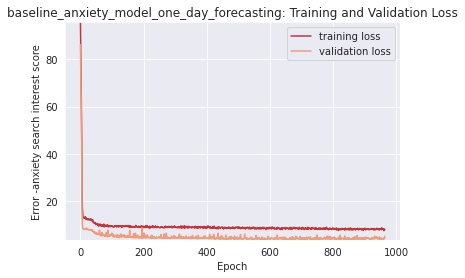


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 10.961180821561653
  * Mean Absolute Deviation of test response values: 11.608314071517949
  * Mean Absolute Error on Validation Set: 3.7373321056365967
  * Mean Absolute Error on Test Set: 4.195318222045898


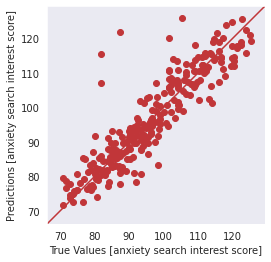

<Figure size 432x288 with 0 Axes>

In [49]:
train_lstm_model(data=top_200_weighted_avg.drop(columns=['date']),
                 labels=individual_search_term_frequencies['anxiety'],
                 step=30,
                 model_name='baseline_anxiety_model_one_day_forecasting',
                 label_name='anxiety search interest score',
                 model_type='one_day_forecasting_baseline')

# Monthly Forecasting

Model Architecture
------------------


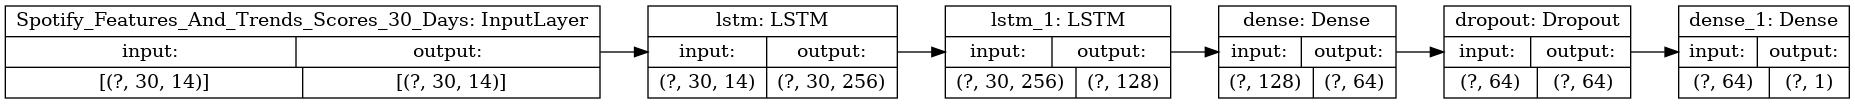


Training History
----------------


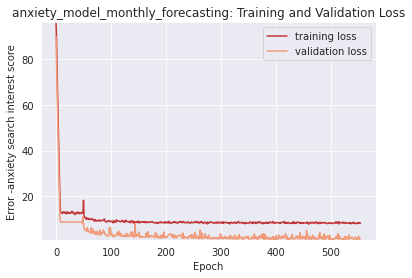


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 9.160604669058074
  * Mean Absolute Deviation of test response values: 9.809651109880722
  * Mean Absolute Error on Validation Set: 0.9261037111282349
  * Mean Absolute Error on Test Set: 1.0123915672302246


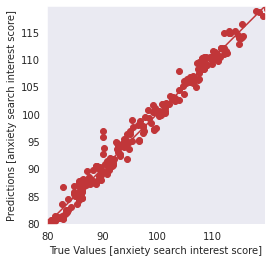

R-Squared Score of Predictions: 0.9858428599707211


<Figure size 432x288 with 0 Axes>

In [13]:
# Google Trends and Spotify
train_lstm_model(data=top_200_weighted_avg.drop(columns=['date']),
                 labels=individual_search_term_frequencies['anxiety'],
                 step=30,
                 model_name='anxiety_model_monthly_forecasting',
                 label_name='anxiety search interest score',
                 model_type='monthly_forecasting')

Model Architecture
------------------


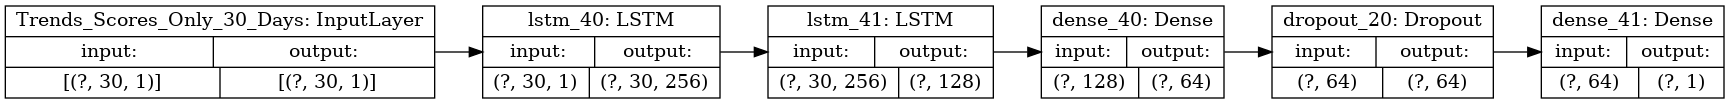


Training History
----------------


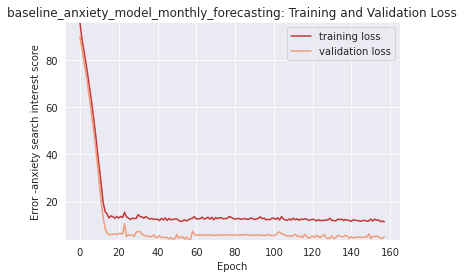


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 9.123060564281417
  * Mean Absolute Deviation of test response values: 9.966283163096872
  * Mean Absolute Error on Validation Set: 3.7692394256591797
  * Mean Absolute Error on Test Set: 4.0834856033325195


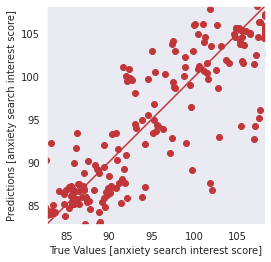

R-Squared Score of Predictions: 0.77825205316156


<Figure size 432x288 with 0 Axes>

In [156]:
# Google Trends Only
train_lstm_model(data=top_200_weighted_avg.drop(columns=['date']),
                 labels=individual_search_term_frequencies['anxiety'],
                 step=30,
                 model_name='baseline_anxiety_model_monthly_forecasting',
                 label_name='anxiety search interest score',
                 model_type='monthly_forecasting_baseline')

Model Architecture
------------------


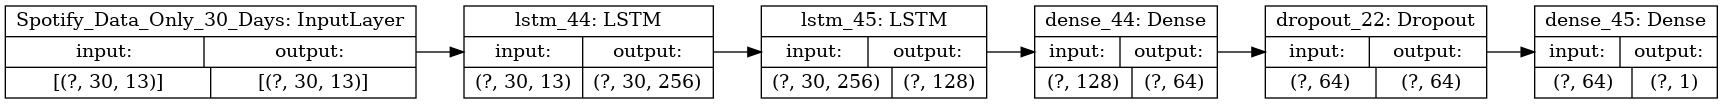


Training History
----------------


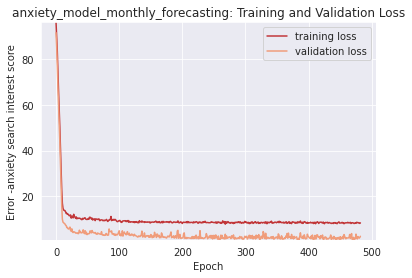


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 9.123060564281417
  * Mean Absolute Deviation of test response values: 9.966283163096872
  * Mean Absolute Error on Validation Set: 0.9799359440803528
  * Mean Absolute Error on Test Set: 1.0915008783340454


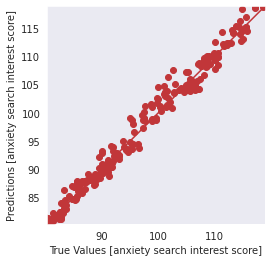

R-Squared Score of Predictions: 0.984064849038924


<Figure size 432x288 with 0 Axes>

In [187]:
# Spotify Only
train_lstm_model(data=top_200_weighted_avg.drop(columns=['date']),
                 labels=individual_search_term_frequencies['anxiety'],
                 step=30,
                 model_name='anxiety_model_monthly_forecasting',
                 label_name='anxiety search interest score',
                 model_type='monthly_forecasting_spotify_only')

In [53]:
# Get spotify + NYT data
spotify_plus_nyt = top_200_weighted_avg.drop(columns=['date']).join(
    news_vectors.drop(columns=['date']))

# 13 song attributes plus 512-dimensional sentence embedding vector representing news headlines for the day = 525
spotify_plus_nyt.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,502,503,504,505,506,507,508,509,510,511
0,0.700672,0.620866,5.516916,-6.817967,0.618192,0.148352,0.175407,0.007983,0.166109,0.489005,...,0.003684,0.035374,0.016044,-0.000216,0.023061,-0.012140,-0.002986,-0.013999,-0.011632,0.008429
1,0.694911,0.603411,5.401974,-6.817318,0.599963,0.154474,0.192934,0.006603,0.157463,0.440288,...,-0.000628,0.020751,0.000568,0.004707,0.005168,-0.004014,-0.007200,0.003860,-0.017291,0.009441
2,0.692630,0.602649,5.415236,-6.824104,0.596881,0.153246,0.194011,0.006792,0.154835,0.438192,...,-0.000661,0.030381,0.013288,0.005367,0.010509,-0.006045,-0.008171,0.003855,-0.007096,0.018201
3,0.692878,0.601787,5.338150,-6.832330,0.586901,0.154600,0.196601,0.006914,0.155729,0.437437,...,0.004361,0.025416,0.006094,0.008971,0.008110,0.000185,-0.012961,0.004362,-0.004057,0.010306
4,0.695205,0.602774,5.399846,-6.798211,0.598931,0.156652,0.196215,0.006865,0.155725,0.439196,...,0.010125,0.020535,0.008477,0.003254,0.008739,-0.000438,-0.007905,0.002326,0.000348,0.014819


Model Architecture
------------------


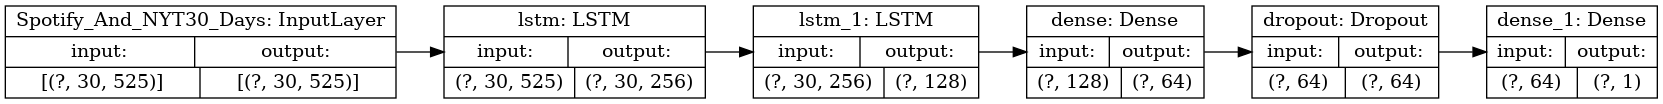


Training History
----------------


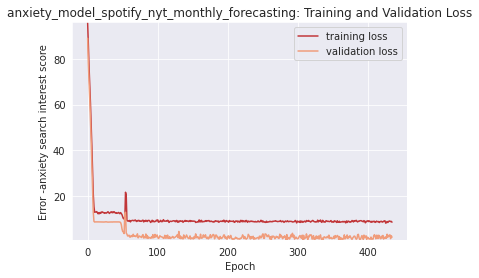


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 9.160604669058074
  * Mean Absolute Deviation of test response values: 9.809651109880722
  * Mean Absolute Error on Validation Set: 0.9143904447555542
  * Mean Absolute Error on Test Set: 0.9458641409873962


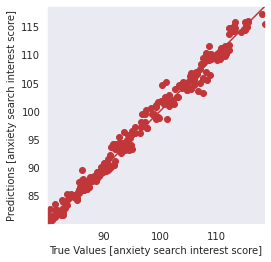

R-Squared Score of Predictions: 0.9876261627745276


<Figure size 432x288 with 0 Axes>

In [54]:
# Spotify and NYT Data:
train_lstm_model(data=spotify_plus_nyt,
                 labels=individual_search_term_frequencies['anxiety'],
                 step=30,
                 model_name='anxiety_model_spotify_nyt_monthly_forecasting',
                 label_name='anxiety search interest score',
                 model_type='monthly_forecasting_spotify_and_nyt')

Model Architecture
------------------


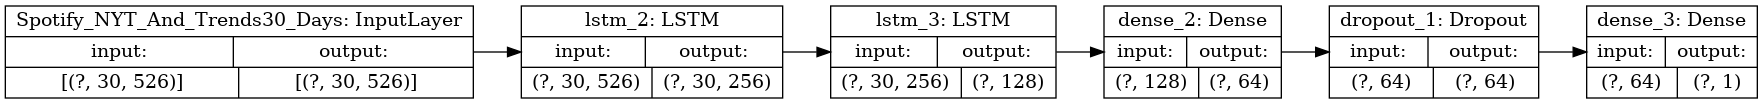


Training History
----------------


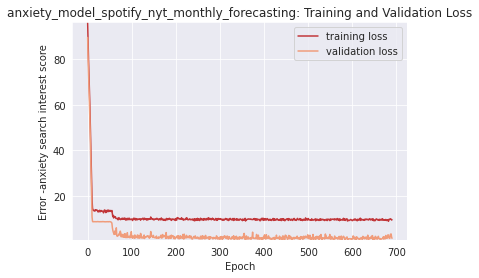


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 9.160604669058074
  * Mean Absolute Deviation of test response values: 9.809651109880722
  * Mean Absolute Error on Validation Set: 0.746199905872345
  * Mean Absolute Error on Test Set: 0.7611586451530457


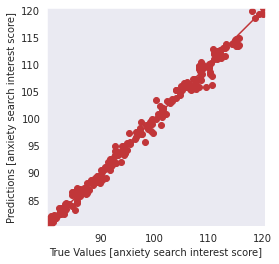

R-Squared Score of Predictions: 0.9917095846729689


<Figure size 432x288 with 0 Axes>

In [55]:
# Spotify + NYT + Trends
train_lstm_model(data=spotify_plus_nyt,
                 labels=individual_search_term_frequencies['anxiety'],
                 step=30,
                 model_name='anxiety_model_spotify_nyt_monthly_forecasting',
                 label_name='anxiety search interest score',
                 model_type='monthly_forecasting_spotify_nyt_and_trends')

Model Architecture
------------------


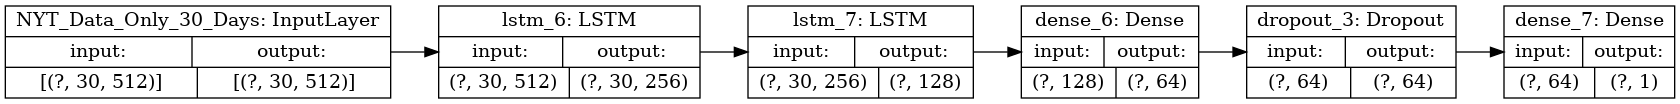


Training History
----------------


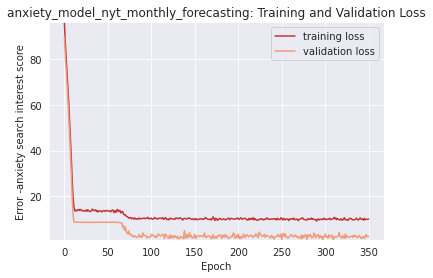


Model Evaluation
----------------
  * Mean Absolute Deviation of train response values: 9.160604669058074
  * Mean Absolute Deviation of test response values: 9.809651109880722
  * Mean Absolute Error on Validation Set: 1.0074188709259033
  * Mean Absolute Error on Test Set: 0.9884629249572754


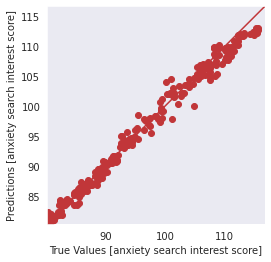

R-Squared Score of Predictions: 0.9855275943012586


<Figure size 432x288 with 0 Axes>

In [60]:
# NYT Only
train_lstm_model(data=news_vectors.drop(columns=['date']),
                 labels=individual_search_term_frequencies['anxiety'],
                 step=30,
                 model_name='anxiety_model_nyt_monthly_forecasting',
                 label_name='anxiety search interest score',
                 model_type='monthly_forecasting_nyt_only')

### Calculate the would-be MAD if we simply built a model which always guessed the average monthly score as the monthly score of the subsequent month

In [181]:
labels = individual_search_term_frequencies['anxiety']

In [182]:
# Train Test Split
random_state = 101
_, _, train_labels, test_labels = train_test_split(labels, labels, test_size=0.2, random_state=random_state)

# Guess the mean of the training set each time:
test_predictions = np.full(shape=test_labels.shape, fill_value=train_labels.mean())

In [183]:
# Calculate the would-be MAD if we simply built a model which always guessed the next month to have
# The same score as the current month
diff = test_predictions - test_labels
mae = np.mean(abs(diff))
print('MAE for Naive Model:', mae)

MAE for Naive Model: 11.362636112487609


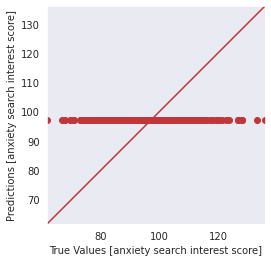

<Figure size 432x288 with 0 Axes>

In [184]:
# Plot Naive Model Predictions
label_name='anxiety search interest score'
model_name='zero_rule_monthly_prediction_model'

a = plt.axes(aspect='equal')

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [' + label_name + ']')
plt.ylabel('Predictions [' + label_name + ']')
lims = [min(test_labels), max(test_labels)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Display the figure
figure = plt.gcf()
display(figure)
plt.close()

plt.savefig('./figures/' + model_name + '_test_scatter_plot.png')

In [186]:
# Calculate R2 Score
print(black('R-Squared Score of Predictions: ', ['bold']), end='')
print(r2_score(y_true=test_labels, y_pred=test_predictions))

R-Squared Score of Predictions: -0.0015942119285192735


### Calculate the would-be MAD if we simply built a model which always guessed the next month to have the same score as the current month

In [174]:
# Define Params
labels = individual_search_term_frequencies['anxiety']
step = 30

trends_list = labels.tolist()
rnn_samples = []

# Collect monthly prediction LSTM data
for i in range(step, len(trends_list) - 30):

    trends_data = np.array(trends_list[i - step: i])
    trends_data = np.expand_dims(trends_data, axis=1)

    sample_set = trends_data
    rnn_samples.append(sample_set)

lstm_data = np.array(rnn_samples)
labels = labels.iloc[step:]

month_scores = []
label_list = labels.to_list()
for i in range(30, len(label_list)):
    month_score = mean(label_list[i-30: i]) # get the mean score for the previous 30 days
    month_scores.append(month_score)

labels = pd.Series(np.array(month_scores))

# Train Test Split
random_state = 101
train_features, test_features, train_labels, test_labels = train_test_split(lstm_data, labels, test_size=0.2, random_state=random_state)

**Note that the lstm data is merely data from 30 days behind the labels**

In [176]:
lstm_data.mean(axis=1)[30:]

array([[ 85.63333333],
       [ 85.66666667],
       [ 85.6       ],
       ...,
       [113.98468853],
       [113.76732643],
       [113.59343674]])

In [177]:
labels

0        85.633333
1        85.666667
2        85.600000
3        85.133333
4        85.166667
           ...    
1300    120.257209
1301    120.083320
1302    119.772017
1303    119.636603
1304    120.250214
Length: 1305, dtype: float64

In [178]:
# Calculate the would-be MAD if we simply built a model which always guessed the next month to have
# The same score as the current month
test_predictions = np.squeeze(test_features.mean(axis=1)) # squeeze simply removes extra unneeded dimensions
diff = test_predictions - test_labels
mae = np.mean(abs(diff))
print('MAE for Naive Model:', mae)

MAE for Naive Model: 3.9761281681476057


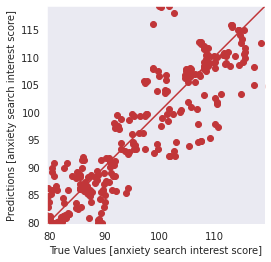

<Figure size 432x288 with 0 Axes>

In [179]:
# Plot Naive Model Predictions
label_name='anxiety search interest score'
model_name='naive_monthly_prediction_model'

a = plt.axes(aspect='equal')

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [' + label_name + ']')
plt.ylabel('Predictions [' + label_name + ']')
lims = [min(test_predictions), max(test_predictions)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Display the figure
figure = plt.gcf()
display(figure)
plt.close()

plt.savefig('./figures/' + model_name + '_test_scatter_plot.png')

In [180]:
# Calculate R2 Score
print(black('R-Squared Score of Predictions: ', ['bold']), end='')
print(r2_score(y_true=test_labels, y_pred=test_predictions))

R-Squared Score of Predictions: 0.767255348838969
